# Set-up

In [105]:
#pip install num2words
!pip install unidecode

In [106]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import unidecode
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [107]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constantes et fonctions

In [218]:
TOP = 50
REGEX = '[a-z0-9]+[#-]?\+{0,2}[a-z0-9]*'

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = []
    
    for w in tknzr.tokenize(unidecode.unidecode(col).lower()):
        if w not in sw and not w.isdigit():
            pos = get_wordnet_pos(w)
            if pos != 'n':
                continue
            else:
                temp.append(stmr.stem(lmtzr.lemmatize(w, pos)))
            
    return ' '.join(temp)

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

# Chargement

In [219]:
freq = defaultdict()

train = pd.read_csv("db_StackOverflow.csv", header=0, encoding='utf-8', \
                    delimiter=',', quotechar='"', index_col=0, )
train.rename_axis(None, inplace=True)
train = train.apply(lambda x: x.astype(str).str.lower())
cols = train.columns

print(train.info())

freq = recap_cols(train, cols) 

train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 169828 to 1669645
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB
None
Dénombrenent des mots
	Title  :  428719 dont  37241 distincts
	Body   : 6055132 dont 561841 distincts
	Tags   :   50000 dont  37101 distincts


,Title,Body,Tags
169828,what are the real benefits of visual studio te...,<p>interested if anyone has used vsts database...,<sql-server><database-tools>
431644,how can i hook into the current formsauthentic...,<p>i've got an httpmodule in my application th...,<asp.net><events><forms-authentication><httpmo...
1450121,is there any sync algorithm/reference availabl...,<p>i'm planning to write a program to sync a f...,<algorithm><synchronization>
426609,how to assign profile values?,"<p>i don't know what i am missing, but i added...",<asp.net><asp.net-mvc><asp.net-membership><pro...
14646,"how to add ""project description"" in fogbugz?",<p>when i create a new project (or even when i...,<fogbugz>


# Nettoyage du dataframe

In [221]:
# Pour étiqueter les tags
lbl = LabelEncoder()

# Stopwords nltk 
std_sw = set(nltk.corpus.stopwords.words('english')) 

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb')

my_sw = std_sw.union(extra_sw)

tokenizer = nltk.RegexpTokenizer(REGEX)
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

print('='*50)

for col in ['Title', 'Body']:
    if col == 'Body':
        print('Conversion html de "{}" '.format(col), end='')
        start_time = timeit.default_timer()

        # Convertion du html en chaine standard 
        train[col] = train[col].apply(conv_html)

        elapsed = timeit.default_timer() - start_time
        print('-> OK en {:.3} sec'.format(elapsed))

    print('Nettoyage/lemmatisation de "{}" '.format(col), end='')
    start_time = timeit.default_timer()

    # Tokenisation et suppression des stopwords
    train[col] = train[col].apply(clean_field, tknzr=tokenizer, \
                                  sw=std_sw, lmtzr=lemmatizer, stmr=stemmer)

    # Suppression des radicaux qui ne me semblent pas discriminants (ex. use, ...)
    # et des chiffres (1, 0, 2003, ...)
    train[col] = train[col].apply(lambda x: ' '.join([w for w in x.split() \
                                                      if w not in extra_sw]))

    elapsed = timeit.default_timer() - start_time
    print('-> OK en {:.3} sec'.format(elapsed))

print('Traitement des tags ', end='')
start_time = timeit.default_timer()

# Epurage et tri des tags
train['Tags'] = train['Tags'].apply(lambda x: ' '.join(sorted(x[1:-1].split('><'))))

# Ajout du nombre de Tags 
train['nTags'] = train['Tags'].apply(lambda x: len(x.split()))

# Etiquetage des tags
#train['Tags_lbl'] = lbl.fit_transform(train.Tags)

elapsed = timeit.default_timer() - start_time
print('-> OK en {:.3} sec'.format(elapsed))

freq = recap_cols(train, cols)

print('{} groupes de tags distincts'.format(len(train.Tags.value_counts())))
print('='*50)

train.head()

Nettoyage/lemmatisation de "Title" -> OK en 49.2 sec
Conversion html de "Body" -> OK en 21.0 sec
Nettoyage/lemmatisation de "Body" 

/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\ud800' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf30' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf3d' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf33' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf3f' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/

-> OK en 3.91e+02 sec
Traitement des tags -> OK en 0.0917 sec
Dénombrenent des mots
	Title  :  216474 dont  13685 distincts
	Body   : 1590802 dont  51710 distincts
	Tags   :  145824 dont  10494 distincts
36891 groupes de tags distincts


,Title,Body,Tags,nTags
169828,benefit studio team system databas edit gdr,anyon vst databas edit featur standard studio ...,database-tools sql-server,2
431644,hook formsauthenticationmodul medium trust env...,httpmodul applic hook formsauthenticationmodul...,asp.net events forms-authentication httpmodule...,5
1450121,sync algorithm refer directori,plan write program sync folder time across mul...,algorithm synchronization,2
426609,assign profil valu,profil properti web config file cannot access ...,asp.net asp.net-membership asp.net-mvc profile,4
14646,project descript fogbugz,project edit sampl project descript project blind,fogbugz,1


In [223]:
train['full']  = train.Title + ' ' + train.Body

## Nombre de mots dans les Title

In [224]:
temp = pd.DataFrame()
temp['len'] = train.Title.apply(lambda x: len(x.split()))
temp.describe()

,len
count,50000.000000
mean,4.329480
std,1.735414
min,0.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,16.000000


## Nombre de mots dans les Body

In [225]:
temp = pd.DataFrame()
temp['len'] = train.Body.apply(lambda x: len(x.split()))
temp.describe()

,len
count,50000.00000
mean,31.81604
std,27.59869
min,0.00000
25%,15.00000
50%,25.00000
75%,40.00000
max,911.00000


In [226]:
backup = train.copy()

# Explorations

## Jeu de données

Text(0.5, 1.0, 'Top 50 dans Tags')

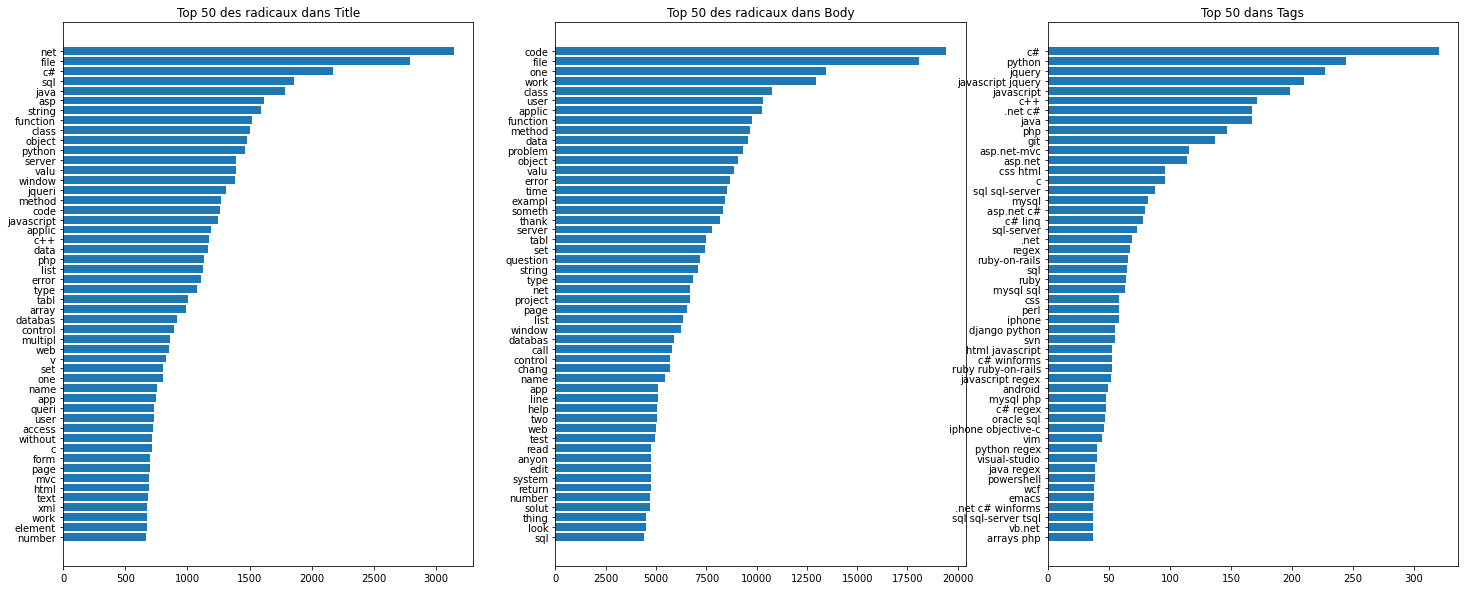

In [293]:
cpt = 0 
fig = plt.figure(figsize=(25, 10))

for col in cols[:-1]:
    cpt += 1
    plt.subplot(1, 3, cpt)
    plt.barh([k for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des radicaux dans {}'.format(TOP, col))

temp = train.Tags.value_counts().to_frame('counts')
plt.subplot(133)
plt.barh(temp.sort_values(by='counts', ascending=True)[-TOP:].index, 
         temp.sort_values(by='counts', ascending=True)[-TOP:].counts)
plt.title('Top {} dans Tags'.format(TOP))

## Top Tags

Text(0.5, 1.0, 'Distribution du nombre de tags par question')

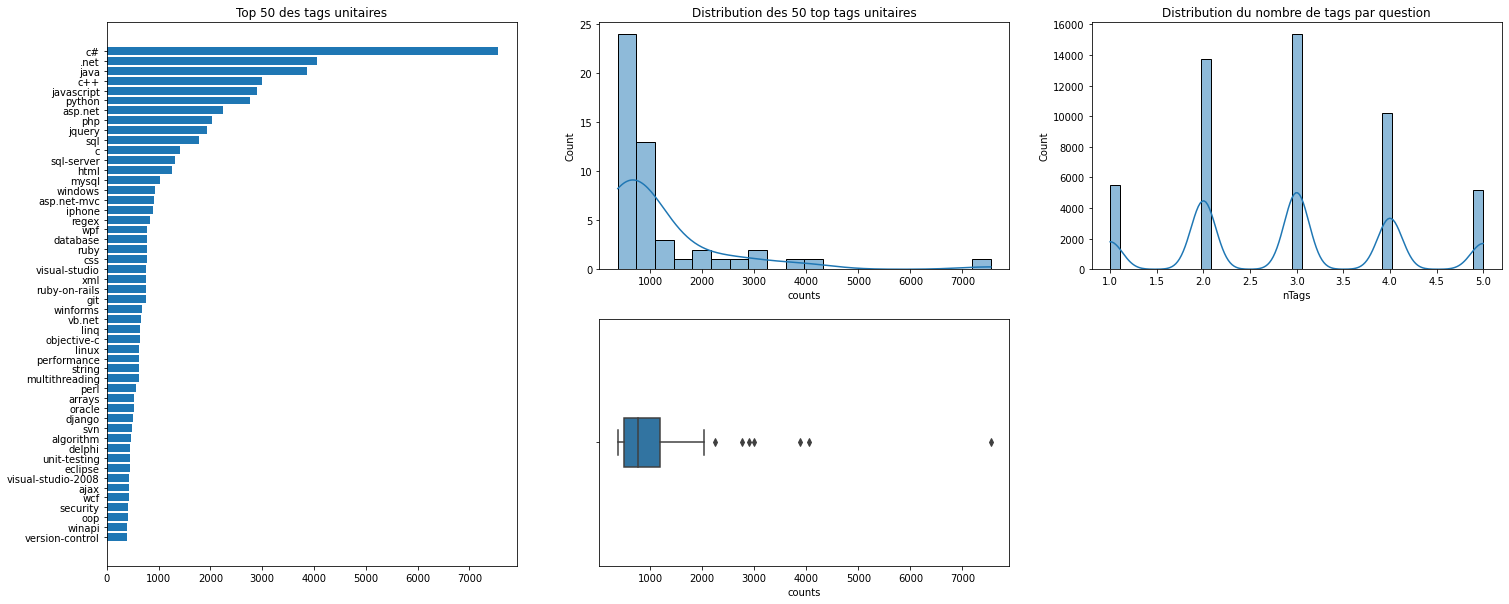

In [294]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(131)
plt.barh([k for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])])
plt.title('Top {} des tags unitaires'.format(TOP))

temp = pd.DataFrame.from_dict(dict(freq['Tags'][:TOP]), orient='index')\
                              .rename(columns={0:'counts'})
plt.subplot(232)
plt.title('Distribution des {} top tags unitaires'.format(TOP))
sns.histplot(temp.counts, kde=True)

plt.subplot(235)
sns.boxplot(x=temp.counts, width=0.2)

plt.subplot(233)
sns.histplot(train['nTags'], kde=True)
plt.title('Distribution du nombre de tags par question')

In [295]:
pd.DataFrame(freq['Tags']).rename(columns={0:'Tag', 1:'count'}).describe()

,count
count,10494.000000
mean,13.895941
std,121.763098
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,7544.000000


In [296]:
train[train.Tags.str.contains("c#")][['Title', 'Body']]

,Title,Body
16,dataset linq queri result set,linq queri asmx web servic busi tier return ty...
4,convert decim c#,track-bar chang form opac code build applic er...
61219,debug assert v thrown except,m net applic john robbin becom evangel debug a...
495351,asp net mvc rc1 renderparti,pa viewdata object master page view user contr...
846496,string behav,someon explain result two statement thought va...
...,...,...
832553,datetimepick net compact framework edit year p...,window mobil applic built c# dotnet studio for...
9868307,limit string,base64 jpeg imag string simpl signatur imag st...
881630,implement mail websit,mail function bebo facebook network site optio...
565075,set valu properti gener getter setter,sure code issu understand set properti valu wi...


# Réduction de dimensions



## Tag unitaires

In [297]:
train_1T = train[train.nTags == 1]
freq = recap_cols(train_1T, cols)
print(train.shape)
train_1T.head()

Dénombrenent des mots
	Title  :   22637 dont   3569 distincts
	Body   :  142483 dont  10348 distincts
	Tags   :    5512 dont    867 distincts
(50000, 5)


,Title,Body,Tags,nTags,full
14646,project descript fogbugz,project edit sampl project descript project blind,fogbugz,1,project descript fogbugz project edit sampl pr...
34017938,decrement valu scheme,procedur n prime paramet n procedur prime rang...,scheme,1,decrement valu scheme procedur n prime paramet...
1023055,point end file gvim,command mode gvim result someon throw bone off...,vim,1,point end file gvim command mode gvim result s...
2177008,mean rubi,mean rubi,ruby,1,mean rubi mean rubi
368947,javascript error thrown ajaxtoolkit net machin,button save ajaxtoolkit c# net error consol st...,.net,1,javascript error thrown ajaxtoolkit net machin...


Réduction aux 50 top tags

Dénombrenent des mots
	Title  :   14360 dont   2332 distincts
	Body   :   85977 dont   7154 distincts
	Tags   :    3481 dont     50 distincts


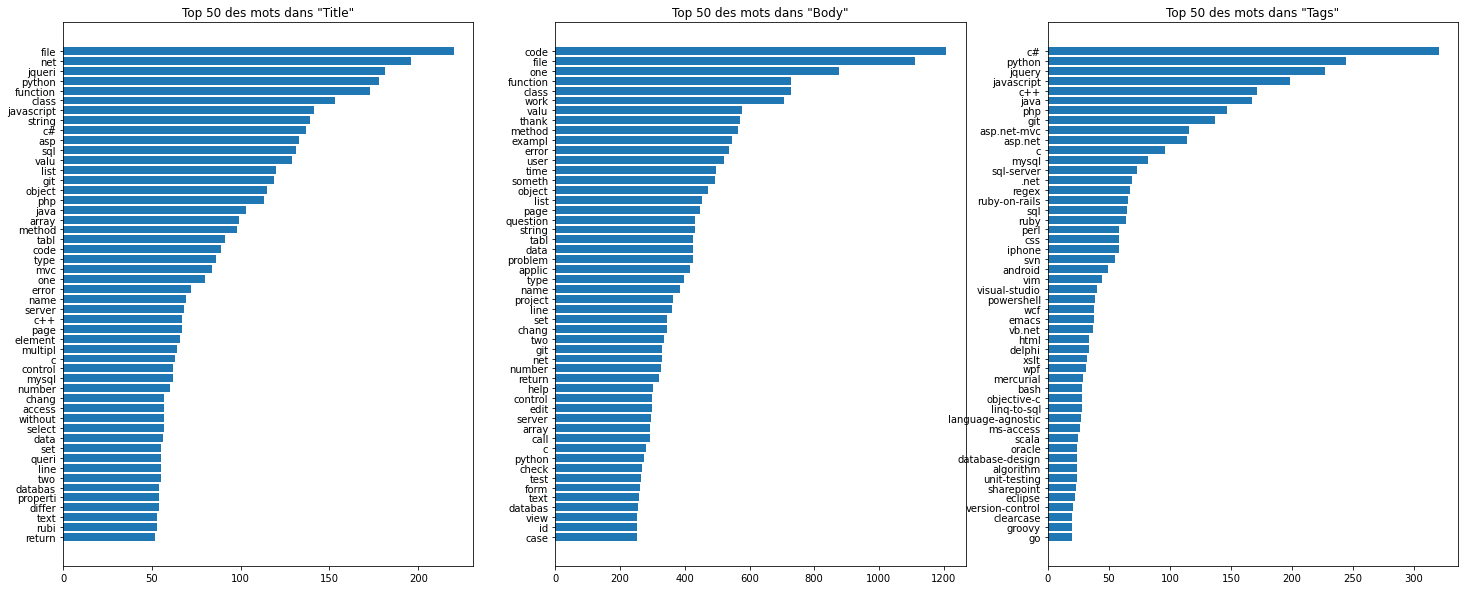

In [298]:
cpt = 1
train_1T = train_1T[train_1T.Tags.isin(dict(freq['Tags'][:TOP]).keys())]

freq = recap_cols(train_1T, cols)

fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

# Réduction du bag of words aux 2 mots les plus féquents pour chaque tag unitaire

In [300]:
# Dictionnaire des index des enrgistrements contenant chaque tag
dict_Tags = defaultdict(dict) 

for i, c in train.iterrows():
    for t in c['Tags'].split():
        try:
            dict_Tags['idx'][t].append(i)
        except KeyError:
            dict_Tags['idx'][t] = [i]

In [306]:
# Ajout des 2 mots les plus utilisés dans TItre et Body pour chaque tag 
tag_kw = set()

for k in dict_Tags['idx'].keys():
    temp = []
    val = train[train.index.isin(dict_Tags['idx'][k])]['full']
    new = Counter(' '.join(val).split()).most_common(2)
    dict_Tags['kw'][k] = new
    for i, j in new:
        tag_kw.add(i)

print('Soit {} radicaux distincts restants'.format(len(tag_kw)))

Soit 4203 radicaux distincts restants


Dénombrenent des mots
	Title  :  194945 dont   4062 distincts
	Body   : 1322511 dont   4183 distincts
	Tags   :  145824 dont  10494 distincts


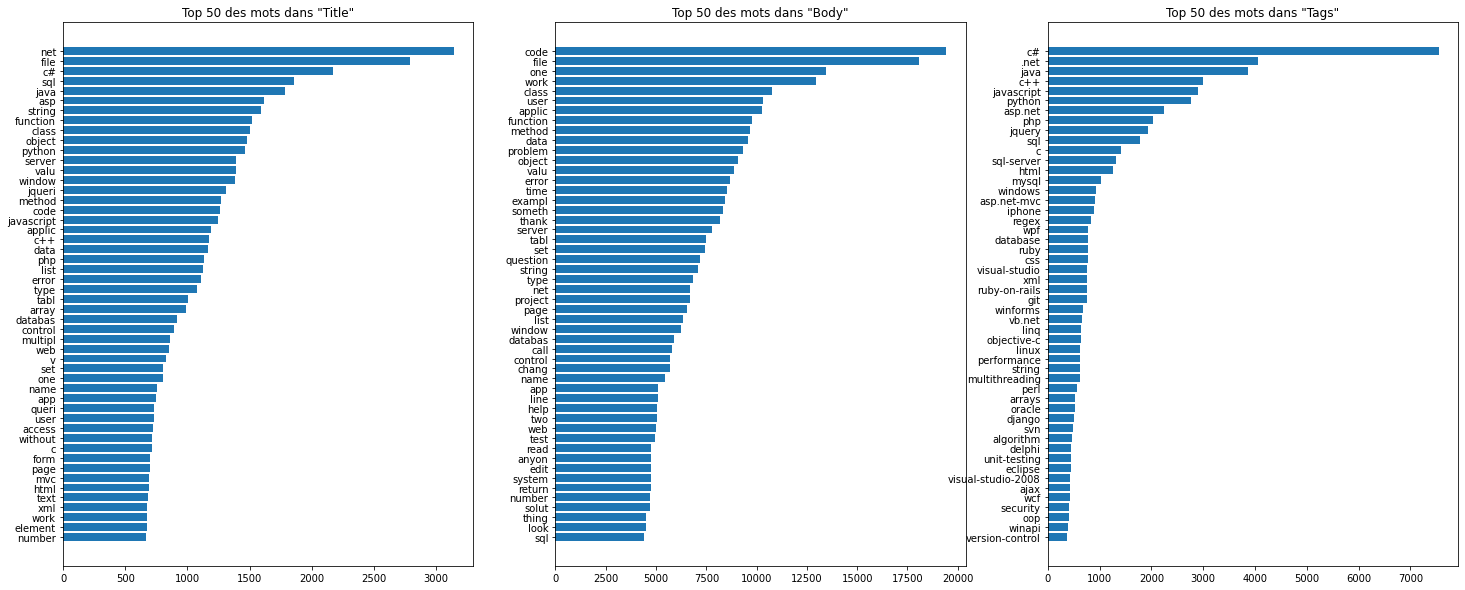

In [302]:
train2 = train.copy()
train2.Title = train2.Title.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))
train2.Body = train2.Body.apply(lambda x: ' '.join([w for w in x.split() if w in tag_kw]))

freq2 = recap_cols(train2, cols)

fig = plt.figure(1, figsize=(25, 10))
cpt=1
for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq2[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(TOP, col))
    cpt += 1 

# Export

In [304]:
with open('OC_DS_P6_backup.pkl', 'wb') as file:
    pickler = pickle.Pickler(file, pickle.HIGHEST_PROTOCOL) 
    pickler.dump(train2)

In [316]:
dict_Tags['kw']

{'database-tools': [('databas', 6), ('edit', 4)],
 'sql-server': [('sql', 2370), ('server', 1879)],
 'asp.net': [('net', 2858), ('asp', 2591)],
 'events': [('event', 667), ('code', 150)],
 'forms-authentication': [('user', 74), ('authent', 69)],
 'httpmodule': [('httpmodul', 13), ('request', 10)],
 'medium-trust': [('trust', 15), ('medium', 14)],
 'algorithm': [('algorithm', 544), ('number', 294)],
 'synchronization': [('thread', 50), ('time', 41)],
 'asp.net-membership': [('net', 72), ('membership', 72)],
 'asp.net-mvc': [('mvc', 1397), ('net', 1152)],
 'profile': [('profil', 27), ('user', 14)],
 'fogbugz': [('fogbugz', 23), ('wiki', 13)],
 'database': [('databas', 1375), ('tabl', 1036)],
 'sql': [('tabl', 2305), ('sql', 2250)],
 'datatable': [('row', 63), ('tabl', 59)],
 'rdbms': [('tabl', 59), ('databas', 28)],
 '.net-3.5': [('net', 247), ('code', 89)],
 'c#': [('c#', 5056), ('code', 4143)],
 'linq': [('linq', 1143), ('queri', 430)],
 'web-services': [('servic', 740), ('web', 531)],